<a href="https://colab.research.google.com/github/justincharney/Python_Machine_Learning/blob/main/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
np.random.seed(42)
import re
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
import pickle

In [ ]:
# connect drive
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
#unzip
!unzip -q '/content/gdrive/MyDrive/aclImdb.zip' -d "content"

In [ ]:
#paths to directories of interest
pos_train_dir = Path('content/aclImdb/train/pos')
neg_train_dir = Path('content/aclImdb/train/neg')

pos_test_dir = Path('content/aclImdb/test/pos')
neg_test_dir = Path('content/aclImdb/test/neg')

vocab = Path('content/aclImdb/imdb.vocab')

# a single positive review
pos_rev = pos_train_dir / "12266_9.txt"

#look at a review
with open(pos_rev, 'r') as rev:
  data = rev.read()
  print(data)

Imagine that I was about to miss this great cultural event on Swedish TV last night, and it was only because my girlfriend insisted on keeping the TV on (to make it easier for her to fall asleep!) that I came across it (yes I had seen an advert for it previously but of course forgotten about it and looked forward to an 'early night'...).<br /><br />Anyway - this must surely be a rather unusual idea - to base a film documentary on an interview made with sound only more than 30 years ago. But with animated and other documentary film material it adds up to a really good and insightful portrait of one of the 20th centuries' most appreciated literary artists - Georges Remy a.k.a Hergé.<br /><br />I for sure will read my Tintin albums with a different eye after having seen this film, which makes it easier to connect the variations in style as well as content with the different periods in Hergé's life (and I can tell you that I will a.s.a.p get the few that I don't have). Of course my percept

#Task 1.1 (simplified)

In [ ]:
class IMDB:

  def __init__(self, pos_train_dir, neg_train_dir):
    self.pos_train_dir = pos_train_dir
    self.neg_train_dir = neg_train_dir
  
  def review_list(self, pos_dir, neg_dir):
    # list of positive reviews
    file_list = []
    for doc in os.scandir(pos_dir):
      d = open(doc, 'r')
      file_list.append(d.read())
      d.close()
    # add the negative reviews
    for doc in os.scandir(neg_dir):
      d = open(doc, 'r')
      file_list.append(d.read())
      d.close()
    return file_list

  def clean_reviews(self, pos_dir, neg_dir):
    cleaned_revs = []
    for review in tqdm(self.review_list(pos_dir, neg_dir)):
      rev= re.sub("[-()\"#/@;:<>{}=~|.?,]", "", review.lower())
      cleaned_revs.append(rev)
    return cleaned_revs
  
  def new_voc(self):
    from collections import Counter
    words = re.compile(r'\w+')
    counts = Counter()
    for review in tqdm(self.clean_reviews(self.pos_train_dir, self.neg_train_dir)):
      counts.update(word for word in set(review.split()))
  
    all_words = [word for word, count in counts.items()]
    remove_words = [word for word, count in counts.items() if (count > 12500 or count < 250)]
    self.new_voc = set(all_words) - set(remove_words)
  
  def pre_process(self, pos_dir, neg_dir):
    # for each review, keep only the words from our vocabulary in our list
    filtered_reviews = []
    for rev in tqdm(self.clean_reviews(pos_dir, neg_dir)):
      words = [word for word in rev.split() if word in self.new_voc]
      string_of_words = ' '.join(words)
      filtered_reviews.append(string_of_words)
    return filtered_reviews
  
  def get_data(self, pos_dir, neg_dir):
    #from sklearn.feature_extraction.text import CountVectorizer
    cv = CountVectorizer(binary=True)
    x = cv.fit_transform(self.pre_process(pos_dir, neg_dir)) # vectorize each review

    y = np.array([]).astype(int)

    for doc in os.scandir(neg_dir):
      d = open(doc, 'r')
      data = d.read()
      d.close()
      rating = int(re.split('(\d+)', str(doc))[3])
      y = np.append(y, rating)
      
    for doc in os.scandir(pos_dir):
      d = open(doc, 'r')
      data = d.read()
      d.close()
      rating = int(re.split('(\d+)', str(doc))[3])
      y = np.append(y, rating)
    
    return x.A, y, cv

In [ ]:
imdb = IMDB(pos_train_dir, neg_train_dir)
new_voc = imdb.new_voc()
#filtered_reviews = imdb.pre_process(pos_train_dir, neg_train_dir)
x_train, y_train, cv = imdb.get_data(pos_train_dir, neg_train_dir)
x_test, y_test, cv_test = imdb.get_data(pos_test_dir, neg_train_dir)

100%|██████████| 25000/25000 [00:01<00:00, 19876.11it/s]


In [ ]:
def get_z_scores(x, y):
  x_n = (x - np.mean(x, axis=0))/np.std(x, axis=0)
  y_n = (y - np.mean(y))/np.std(y)

  z_scores = np.matmul(np.transpose(x_n), y_n)/np.sqrt(x_n.shape[0])
  return z_scores

In [ ]:
z_scores = get_z_scores(x_train, y_train)

In [ ]:
def ten_best_worst(z_scores, cv):
  ten_largest_z_inds = np.argpartition(z_scores, -10)[-10:]
  ten_smallest_z_inds = np.argpartition(z_scores, 10)[:10]
  print("10 most negative features: ", cv.get_feature_names_out()[ten_largest_z_inds]) # 10 most negative features
  print("10 most positive features: ", cv.get_feature_names_out()[ten_smallest_z_inds]) # 10 most positive features

  twenty_best_inds = np.concatenate([ten_smallest_z_inds, ten_largest_z_inds])
  twenty_best_feats = cv.get_feature_names_out()[twenty_best_inds]
  twenty_best_zs = z_scores[twenty_best_inds]

  plt.barh(twenty_best_feats, twenty_best_zs)
  plt.title("Bar Plot of Z-scores for 20 most important IMDB features")
  plt.ylabel("Features")
  plt.xlabel("Z-scores")
  plt.show() 
  return

10 most negative features:  ['nothing' 'no' 'waste' 'awful' 'bad' 'boring' 'worst' 'terrible' 'worse'
 'stupid']
10 most positive features:  ['beautiful' 'great' 'love' 'wonderful' 'excellent' 'amazing' 'best'
 'perfect' 'loved' 'favorite']


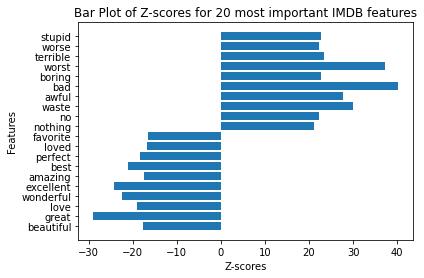

In [ ]:
ten_best_worst(z_scores, cv)

In [ ]:
# get the top 100 features by absolute z-score
best_inds = np.argpartition(np.absolute(z_scores), -100)[-100:]
best_features = best_inds[np.argsort(np.absolute(z_scores[best_inds]))] # sort the best features
best_imdb_feats = cv.get_feature_names_out()[best_features]
print("100 most important features: ", cv.get_feature_names_out()[best_features])

100 most important features:  ['they' 'perfectly' 'strong' 'dumb' 'bunch' 'predictable' 'years' 'guess'
 'didn' 'excuse' 'better' 'terrific' 'family' 'only' 'anything' 'young'
 'garbage' 'heart' 'if' 'reason' 'make' 'decent' 'world' 'well' 'save'
 'unfortunately' 'enjoyed' 'there' 'could' 'touching' 'today' 'or'
 'always' 'couldn' 'life' 'redeeming' 'wonderfully' 'performances' 'least'
 'fails' 'very' 'beautifully' 'both' 'instead' 'pathetic' 'unless'
 'performance' 'cheap' 'mess' 'why' 'oh' 'wasted' 'fantastic' 'laughable'
 'any' 'brilliant' 'dull' 'thing' 'badly' 'highly' 'also' 'superb'
 'annoying' 'just' 'pointless' 'avoid' 'don' 'favorite' 'script' 'money'
 'loved' 'ridiculous' 'amazing' 'beautiful' 'acting' 'lame' 'poorly'
 'even' 'perfect' 'crap' 'love' 'plot' 'minutes' 'supposed' 'poor'
 'horrible' 'best' 'nothing' 'no' 'worse' 'wonderful' 'boring' 'stupid'
 'terrible' 'excellent' 'awful' 'great' 'waste' 'worst' 'bad']


In [ ]:
# define the processed training and testing data
x_train_imdb, y_train_imdb  = x_train[:, best_features], y_train
x_test_imdb, y_test_imdb = x_test[:, best_features], y_test

#Task 1.2 (adjusted)

In [ ]:
from sklearn.datasets import fetch_20newsgroups 

categories = ['comp.graphics', 'rec.sport.hockey', 'sci.med', 'soc.religion.christian']

newsgroups = fetch_20newsgroups(subset='train', categories=categories, remove=(['headers', 'footers', 'quotes']), shuffle=True, random_state=42)

In [ ]:
#remove stopwords that appear in more than 50% or less than 1% of samples
data = newsgroups.data
data[0]

"It is not true that dermatologists gave not reached the laser age, in\nfact, lasers in dermatological surgery is a very new and exciting field.\n\nIt probably won't be effective in tinea pedis because the laser is\nusually a superficial burn (to avoid any deeper damage). Limited tinea\npedis can be cured albeit sometimes slowly by topical antifungals as\nwell as systemic medication i.e. tablets. Finally, a self-diagnosis is\nnot always reliable, lichen simplex chronicus can look like a fungal\ninfection and requires very different treatment."

In [ ]:
from collections import Counter

def clean_text(lst):
    cleaned_texts = []
    for review in tqdm(lst):
      rev= re.sub("[-()\"#/@;:<>{}=~|.?,]", "", review.lower())
      cleaned_texts.append(rev)
    return cleaned_texts

def new_voc(lst):
    words = re.compile(r'\w+')
    counts = Counter()
    for review in tqdm(clean_text(lst)):
      counts.update(word for word in set(review.split()))
  
    all_words = [word for word, count in counts.items()]
    remove_words = [word for word, count in counts.items() if (count > int(0.5*2377) or count < int(0.01*2377))]
    new_voc = set(all_words) - set(remove_words)
    return new_voc

In [ ]:
news_voc = new_voc(data)

100%|██████████| 2377/2377 [00:00<00:00, 19828.44it/s]


In [ ]:
filtered_data = []
for rev in tqdm(clean_text(data)):
  words = [word for word in rev.split() if word in news_voc]
  string_of_words = ' '.join(words)
  filtered_data.append(string_of_words)

100%|██████████| 2377/2377 [00:00<00:00, 23945.63it/s]


In [ ]:
filtered_data[0]

"not true gave not age fact surgery very new field probably won't be effective because usually avoid any limited can be sometimes by as well as ie finally not always can look like requires very different treatment"

In [ ]:
#tokenizing X
count_vect = CountVectorizer(stop_words='english', strip_accents='ascii')

x = count_vect.fit_transform(filtered_data)
print(x.shape)

(2377, 1320)


In [ ]:
#tfidf
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
x_f = transformer.fit_transform(x)
x_f.shape

(2377, 1320)

In [ ]:
x_f = x_f.A # turn into numpy array
y_news = newsgroups.target

In [ ]:
# mutual info calculation
#from sklearn.metrics import mutual_info_score
#mis_per_label = []
#for y in np.unique(y_news, axis=0): #for each unique label (there are 4)
#  mis = {} 
#  inds = np.where(y_news == y) # find the row indices with that label
#  y_v = y_news[inds] #get a vector with all labels for that label
#  x_v = x_f[inds] # get training input corresponding to the label
#  for i,feat in enumerate(x_v.T): # for each input feature calculate mutual information
#    mi = mutual_info_score(y_v, feat)
#    mis[i] = mi # create dictionary with mutual information for each feature index
#  mis_per_label.append(mis)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.

In [ ]:
# pickle result

#with open('/content/gdrive/MyDrive/mis_per_label.pickle', 'wb') as p:
#  pickle.dump(mis_per_label, p)

#load pickle
with open('/content/gdrive/MyDrive/mis_per_label.pickle', 'rb') as p:
    mis_per_label = pickle.load(p)

In [ ]:
#Keeping differing amount of features
unfiltered_inds = []
unfiltered_inds_50 = []
unfiltered_inds_10 = []
for mis in mis_per_label:
  mis_sorted = dict(sorted(mis.items(), key=lambda item: item[1])[-100:]) # sort the mutual info and keep 100 highest
  mis_sorted_50 = dict(sorted(mis.items(), key=lambda item: item[1])[-50:]) #keep the 50 highest (for experiments later)
  mis_sorted_10 = dict(sorted(mis.items(), key=lambda item: item[1])[-10:]) #keep the 10 highest (for experiments later)
  #print(mis_sorted)
  inds = unfiltered_inds.append(mis_sorted.keys())
  inds50 = unfiltered_inds_50.append(mis_sorted_50.keys())
  inds10 = unfiltered_inds_10.append(mis_sorted_10.keys())

#keep only the unique indices
x_inds = {x for l in unfiltered_inds for x in l}
x_inds = [ int(x) for x in x_inds ]
x_inds = np.array(x_inds)

#same for 50 and 10 (for experiments later)
x_inds_50 = {x for l in unfiltered_inds_50 for x in l}
x_inds_50 = [ int(x) for x in x_inds_50 ]
x_inds_50 = np.array(x_inds_50)

x_inds_10 = {x for l in unfiltered_inds_10 for x in l}
x_inds_10 = [ int(x) for x in x_inds_10 ]
x_inds_10 = np.array(x_inds_10)

In [ ]:
x_news_feats = count_vect.get_feature_names_out()[x_inds]
x_news_feats

array(['00', '100', '19', '1992', '1993', '1st', '21', '22', '23', '24',
       '256', '26', '28', '32', '35', '43', '80', 'abc', 'accept',
       'account', 'accurate', 'action', 'actual', 'added', 'addition',
       'admit', 'advantage', 'advice', 'alternative', 'america',
       'analysis', 'angeles', 'announced', 'anonymous', 'answers',
       'appear', 'application', 'applied', 'areas', 'argue', 'argument',
       'articles', 'asking', 'aspects', 'assume', 'assuming', 'atheist',
       'attention', 'avoid', 'beginning', 'bob', 'born', 'bother', 'box',
       'brian', 'brother', 'brought', 'calling', 'canada', 'career',
       'caused', 'century', 'chicago', 'choose', 'chris', 'claimed',
       'class', 'clearly', 'club', 'community', 'company', 'compare',
       'context', 'copy', 'create', 'culture', 'cup', 'data', 'dave',
       'deleted', 'details', 'determine', 'develop', 'development',
       'died', 'disagree', 'division', 'doctor', 'doctors', 'doubt', 'dr',
       'drive', 

In [ ]:
# now we will only keep the most important features from our original input x
x_news= x_f[:, x_inds]
print(x_news.shape)

#same for 50 and 10
x_news_50= x_f[:,x_inds_50]
print(x_news_50.shape)

x_news_10= x_f[:, x_inds_10]
print(x_news_10.shape)

(2377, 346)
(2377, 181)
(2377, 38)


In [ ]:
# do the same pre processing for the test set
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove= (['headers', 'footers', 'quotes']), shuffle=True, random_state=42)

#vectorize with vocabulary pre-determined
keep_words = count_vect.get_feature_names_out()[x_inds]
keep_words = keep_words.tolist()
cv = CountVectorizer(vocabulary=keep_words)
x_test = cv.fit_transform(newsgroups_test.data)

# for experiments later
keep_words_50 = count_vect.get_feature_names_out()[x_inds_50]
keep_words_50 = keep_words_50.tolist()
cv50 = CountVectorizer(vocabulary=keep_words_50)
x_test_50 = cv50.fit_transform(newsgroups_test.data)

keep_words_10 = count_vect.get_feature_names_out()[x_inds_10]
keep_words_10 = keep_words_10.tolist()
cv10 = CountVectorizer(vocabulary=keep_words_10)
x_test_10 = cv10.fit_transform(newsgroups_test.data)

#tfidf
x_news_test = transformer.fit_transform(x_test)
x_news_test = x_news_test.A # turn into np array

#for experiments later
x_news_test_50 = transformer.fit_transform(x_test_50)
x_news_test_50 = x_news_test_50.A # turn into np array

x_news_test_10 = transformer.fit_transform(x_test_10)
x_news_test_10 = x_news_test_10.A # turn into np array

#get labels 
y_news_test = newsgroups_test.target
print(x_news_test.shape)
print(x_news_test_50.shape)
print(x_news_test_10.shape)

(1582, 346)
(1582, 181)
(1582, 38)


In [ ]:
# one-hot encode y
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

y_news = enc.fit_transform(y_news.reshape(-1,1))
y_news_test = enc.fit_transform(y_news_test.reshape(-1,1))

In [ ]:
# turn into numpy arrays
y_news = y_news.A
y_news_test = y_news_test.A

# Task 2

In [ ]:
# Math functions
logistic = lambda a: 1./(1+np.exp(-a)) 
J = lambda y,a: np.mean(y * np.log1p(np.exp(-a)) + (1-y) * np.log1p(np.exp(a)))
dJ = lambda x, y, y_hat: np.dot(x.T, y_hat - y)/x.shape[0]
accuracy = lambda y, y_hat: np.sum(y_hat == y)/len(y)

In [ ]:
# logistic regression for IMDB data

class LogisticRegressor:
  def __init__(self):
    self.w = 0
    
  def fit(self, x, y, plot=True, alpha=0.02, eps=1e-5, max_iter=2000, batch_size=0):
    if batch_size < 1:
      batch_size=x.shape[0]

    w = np.zeros(x.shape[1])
    #w = np.random.normal(size = x.shape[1]) # randomly initialize the weights

    #prev_loss = np.inf

    losses = []
    
    #initialize loss
    prev_loss=np.zeros(int(len(x)/batch_size))
    for i in range(len(prev_loss)):
      prev_loss[i] = np.inf
    
    for iter in tqdm(range(max_iter)):
      for i in range(int(len(x)/batch_size)):
        x_batch = x[i*batch_size:(batch_size*(i+1)),:]#x_df.sample(frac=0.2, random_state=42).to_numpy()
        y_batch = y[i*batch_size:(batch_size*(i+1))]#y_df.sample(frac=0.2, random_state=42).to_numpy().squeeze()
        a = np.dot(x_batch, w)
        y_hat = logistic(a)
        loss = J(y_batch, a)
        losses.append(loss)
        w = w - alpha*dJ(x_batch, y_batch, y_hat)
        if np.linalg.norm(loss - prev_loss[i]) < eps:
          break
          break
        else:
          prev_loss[i] = loss
        
    self.w = w
    if plot:
      plt.plot(losses)
      plt.ylabel("Cross entropy")
      plt.xlabel("iteration")
      plt.show()

  def predict(self, x, threshold=0.5):
    return logistic(np.dot(x,self.w))>=threshold

In [ ]:
# Confusion Matrix
def confusion_matrix (predictions, labels):
  matrix = np.zeros([2,2])
  matrix[0,0] = np.sum(((predictions==0)*(labels==0)))
  matrix[0,1] = np.sum(predictions*(labels==0))
  matrix[1,0] = np.sum((predictions==0)*labels)
  matrix[1,1] = np.sum(predictions*labels)
  return matrix

In [ ]:
# a function to calculate the Riemann sum of a curve
def area_under_curve(x,y):
  area = 0
  for i in range(1, len(x+1)):
    area += abs(x[i]-x[i-1])*(abs(y[i]-y[i-1])/2+y[i-1])
  return area

In [ ]:
# A function to make ROC curves for Multiple and Binary Logistic Regression
def ROC(Model: LogisticRegressor, y, x, knn_tpr, knn_fpr, knn_auc, plot=False, thresholds=[1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0, -1]): #thresholds need to be given in descending order
  FPR = np.zeros(len(thresholds))
  TPR = np.zeros(len(thresholds))
  for i in tqdm(range(len(thresholds))):
    predictions = Model.predict(x, threshold= thresholds[i])
    confusion = confusion_matrix(predictions, y)
    FPR[i] = confusion[0,1]/(confusion[0,1]+confusion[0,0])
    TPR[i] = confusion[1,1]/(confusion[1,0]+confusion[1,1])
  if plot:
    plt.plot(FPR, TPR, 'b', label="AUC: "+str(round(area_under_curve(FPR, TPR),2)))
    plt.plot(knn_fpr, knn_tpr, 'r', label = 'KNN AUC = %0.2f' % knn_auc)
    plt.legend(loc = 'lower right')
    plt.title("ROC Curve")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc = 'lower right')
    #plt.text(0.8,0.1,"AUC: "+str(round(area_under_curve(FPR, TPR),2)))
    plt.show()
  return area_under_curve(FPR, TPR)
  

100%|██████████| 2000/2000 [00:28<00:00, 69.72it/s]


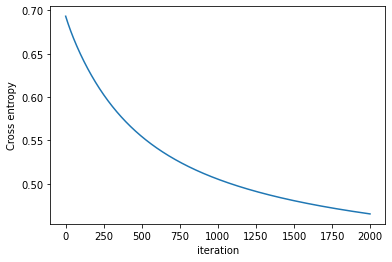

In [ ]:
log_r = LogisticRegressor()

log_r.fit(x_train_imdb, y_train_imdb > 4, batch_size=0) # turning y_train_imdb into a binary label

100%|██████████| 2000/2000 [00:53<00:00, 37.34it/s]


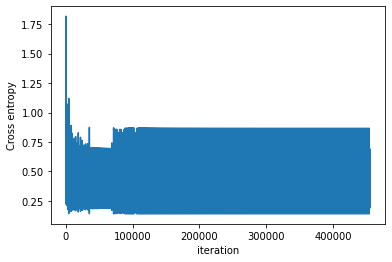

In [ ]:
#minibatch test
log_r = LogisticRegressor()

log_r.fit(x_train_imdb, y_train_imdb > 4, batch_size=100) # turning y_train_imdb into a binary label

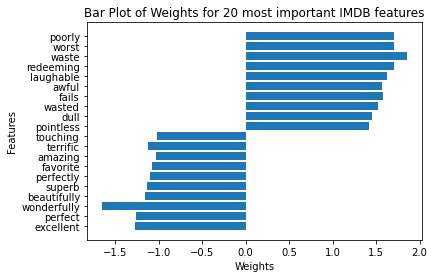

In [ ]:
#get the weights from the LR model
lr_weights = log_r.w

#get the indices of the 10 largest weights
ten_largest_inds = np.argpartition(lr_weights, -10)[-10:]

#get the indices of the 10 smallest weights
ten_smallest_inds = np.argpartition(lr_weights, 10)[:10]

twenty_best_w_inds = np.concatenate([ten_smallest_inds, ten_largest_inds])
twenty_best_feats = best_imdb_feats[twenty_best_w_inds]
twenty_best_ws = lr_weights[twenty_best_w_inds]

plt.barh(twenty_best_feats, twenty_best_ws)
plt.title("Bar Plot of Weights for 20 most important IMDB features")
plt.ylabel("Features")
plt.xlabel("Weights")
plt.show() 

In [ ]:
# training accuracy
accuracy(y_train_imdb>4, log_r.predict(x_train_imdb))

0.8034

In [ ]:
# testing accuracy
imdb_testing_acc = accuracy(y_test_imdb>4, log_r.predict(x_test_imdb))
imdb_testing_acc

0.7994

In [ ]:
class MultipleLogisticRegressor:
  def __init__(self, classes):
    self.w = 0
    self.classes = classes

  def fit(self, x, y, plot=False, alpha=0.02, eps=1e-5, max_iter=1000, batch_size=0):
    if batch_size < 1:
      batch_size=x.shape[0]

    self.w = np.random.random((x.shape[1], self.classes)) # randomly initialize the weights

    losses = []
    
    #initialize loss
    prev_loss=np.zeros(int(len(x)/batch_size))
    for i in range(len(prev_loss)):
      prev_loss[i] = np.inf

    for iter in tqdm(range(max_iter)):
      for i in range(int(len(x)/batch_size)):
        x_batch = x[i*batch_size:(batch_size*(i+1)),:]#x_df.sample(frac=0.2, random_state=42).to_numpy()
        y_batch = y[i*batch_size:(batch_size*(i+1)), :]
        loss=self.loss(y_batch, x_batch)
        losses.append(loss)
        if np.linalg.norm(loss - prev_loss[i]) < eps:
          break
          break
        else:
          prev_loss[i] = loss
          self.w = self.w - alpha*self.gradient(x_batch, y_batch)
    if plot: 
      plt.plot(losses)
      plt.ylabel("Cross entropy")
      plt.xlabel("iteration")
      plt.show()

  def predict(self, x):
    a = np.dot(x, self.w)
    predictions = np.exp(a - np.max(a)) # adjusted for numerical stability
    return predictions/np.sum(predictions, axis=1).reshape(x.shape[0],1)

  def loss(self, y, x):
    return np.average(-y*np.log(self.predict(x) + 1e-9))

  def gradient(self, x, y): 
    return np.matmul(x.T, self.predict(x) - y)

  def mult_accuracy(self, y, y_hat):
    eq_rows = sum(y_hat.argmax(axis=1) == y.argmax(axis=1))
    return eq_rows/len(y)

100%|██████████| 1000/1000 [00:05<00:00, 184.77it/s]


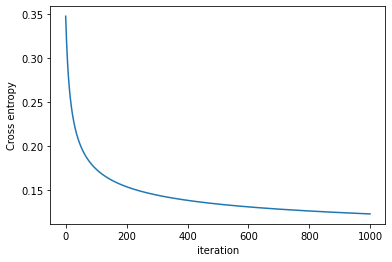

In [ ]:
# Multiclass regression on newsgroup data

multi_r = MultipleLogisticRegressor(4)
multi_r.fit(x_news, y_news, plot=True, batch_size=0)

In [ ]:
news_testing_acc = multi_r.mult_accuracy(y_news_test, multi_r.predict(x_news_test))
news_testing_acc

0.6833122629582806

In [ ]:
#heat map. 5 most positive features for each class as the rows (20 rows) and the 4 classes as the columns

#get the weights for each of the 4 classes
w_1 = multi_r.w[:,0]
w_2 = multi_r.w[:,1]
w_3 = multi_r.w[:,2]
w_4 = multi_r.w[:,3]

#get the indices of the 5 largest weights in each class
w_1_5 = np.argpartition(w_1, -5)[-5:]
w_2_5 = np.argpartition(w_2, -5)[-5:]
w_3_5 = np.argpartition(w_3, -5)[-5:]
w_4_5 = np.argpartition(w_4, -5)[-5:]

#get the features corresponding to the 5 largest weights for each class
f_1_5 = x_news_feats[w_1_5]
f_2_5 = x_news_feats[w_2_5]
f_3_5 = x_news_feats[w_3_5]
f_4_5 = x_news_feats[w_4_5]

#features
feat_names = np.concatenate([f_1_5, f_2_5, f_3_5, f_4_5])

# indices of all the features 
feat_indices = np.concatenate([w_1_5, w_2_5, w_3_5, w_4_5])

#weights from each class for all feature indices
feat_weights_1 = w_1[feat_indices]
feat_weights_2 = w_2[feat_indices]
feat_weights_3 = w_3[feat_indices]
feat_weights_4 = w_4[feat_indices]
# concatenate above into a matrix for heat map
matrix = np.vstack((feat_weights_1, feat_weights_2, feat_weights_3, feat_weights_4)).T
matrix.shape

(20, 4)

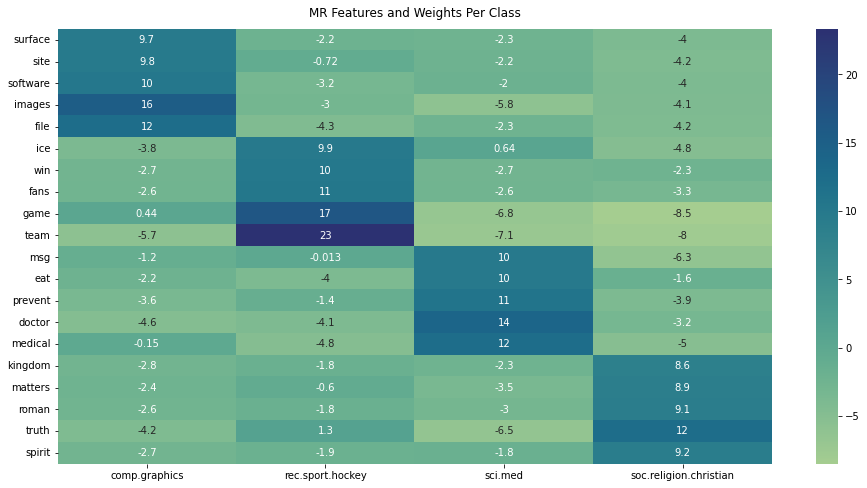

In [ ]:
import seaborn as sns
plt.figure(figsize=(16, 8))

heatmap = sns.heatmap(matrix, yticklabels=feat_names, xticklabels=categories, annot=True, cmap="crest")
heatmap.set_title('MR Features and Weights Per Class', pad=12);

#LR Experiments

In [ ]:
#COMPARE WITH KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)

# need to standardize the data
x_train_imdb = (x_train_imdb - np.mean(x_train_imdb))/np.std(x_train_imdb)
x_test_imdb = (x_test_imdb - np.mean(x_test_imdb))/np.std(x_test_imdb)

knn.fit(x_train_imdb, y_train_imdb > 4) # train knn with binary label

knn_preds = knn.predict(x_test_imdb)
accuracy(y_test_imdb>4, knn_preds)

0.86596

100%|██████████| 12/12 [00:00<00:00, 377.13it/s]


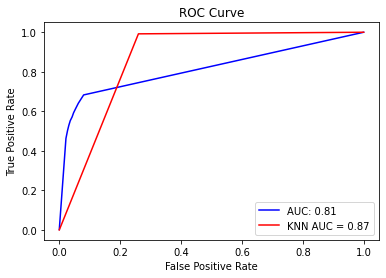

In [ ]:
#AUC for knn
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#probs = knn.predict_proba(x_test_imdb)
fpr, tpr, thresholds = roc_curve(y_test_imdb>4, knn_preds)
knn_auc = auc(fpr, tpr)

#pass these values to the ROC plotting function
lr_auc = ROC(log_r, y_test_imdb>4, x_test_imdb, tpr, fpr, knn_auc, plot=True)

In [ ]:
# determine accuracy of logistic regression model as a function of training data size
import pandas as pd

#convert training data to pandas dataframe
x_imdb_df = pd.DataFrame(x_train_imdb)
y_imdb_df = pd.DataFrame(y_train_imdb)

# randomly select several percentages for training
x_imdb_twenty = x_imdb_df.sample(frac=0.2, random_state=42).to_numpy()
y_imdb_twenty = y_imdb_df.sample(frac=0.2, random_state=42).to_numpy().squeeze()

x_imdb_fourty = x_imdb_df.sample(frac=0.4, random_state=42).to_numpy()
y_imdb_fourty = y_imdb_df.sample(frac=0.4, random_state=42).to_numpy().squeeze()

x_imdb_sixty = x_imdb_df.sample(frac=0.6, random_state=42).to_numpy()
y_imdb_sixty = y_imdb_df.sample(frac=0.6, random_state=42).to_numpy().squeeze()

x_imdb_eighty = x_imdb_df.sample(frac=0.8, random_state=42).to_numpy()
y_imdb_eighty = y_imdb_df.sample(frac=0.8, random_state=42).to_numpy().squeeze()

#logistic regression for fractions of training data
# train on 20%
log_r.fit(x_imdb_twenty, y_imdb_twenty > 4, plot=False)
imdb_twenty_acc = accuracy(y_test_imdb>4, log_r.predict(x_test_imdb))
print("Testing accuracy using 20% training data: ", imdb_twenty_acc)

# train on 40%
log_r.fit(x_imdb_fourty, y_imdb_fourty > 4, plot=False)
imdb_fourty_acc = accuracy(y_test_imdb>4, log_r.predict(x_test_imdb))
print("Testing accuracy using 40% training data: ", imdb_fourty_acc)

# train on 60%
log_r.fit(x_imdb_sixty, y_imdb_sixty > 4, plot=False)
imdb_sixty_acc = accuracy(y_test_imdb>4, log_r.predict(x_test_imdb))
print("Testing accuracy using 60% training data: ", imdb_sixty_acc)

# train on 80%
log_r.fit(x_imdb_eighty, y_imdb_eighty > 4, plot=False)
imdb_eighty_acc = accuracy(y_test_imdb>4, log_r.predict(x_test_imdb))
print("Testing accuracy using 80% training data: ", imdb_eighty_acc)


100%|██████████| 2000/2000 [00:01<00:00, 1004.75it/s]


Testing accuracy using 20% training data:  0.8122


100%|██████████| 2000/2000 [00:04<00:00, 499.85it/s]


Testing accuracy using 40% training data:  0.81372


100%|██████████| 2000/2000 [00:06<00:00, 324.34it/s]


Testing accuracy using 60% training data:  0.8142


100%|██████████| 2000/2000 [00:08<00:00, 236.34it/s]

Testing accuracy using 80% training data:  0.81584


<function matplotlib.pyplot.show(*args, **kw)>

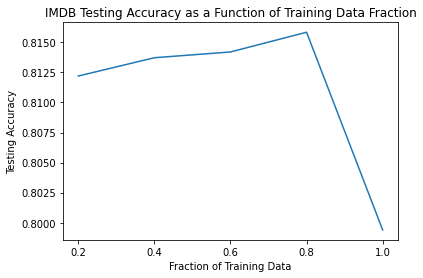

In [ ]:
# testing accuracy as a function of trainin data size
accuracies = [imdb_twenty_acc, imdb_fourty_acc, imdb_sixty_acc, imdb_eighty_acc, imdb_testing_acc]
data_fracs = ['0.2', '0.4', '0.6', '0.8', '1.0']

plt.plot(data_fracs, accuracies)
plt.title("IMDB Testing Accuracy as a Function of Training Data Fraction")
plt.ylabel("Testing Accuracy")
plt.xlabel("Fraction of Training Data")
plt.show

In [ ]:
def aucs(fracs=[0.2, 0.4, 0.8, 1]):
  from sklearn.metrics import auc

  knn_aucs = []
  lr_aucs = []

  #convert training data to pandas dataframe
  x_imdb_df = pd.DataFrame(x_train_imdb)
  y_imdb_df = pd.DataFrame(y_train_imdb)

  for f in fracs:
    # randomly select percentage for training
    x_imdb_frac = x_imdb_df.sample(frac=f, random_state=42).to_numpy()
    y_imdb_frac = y_imdb_df.sample(frac=f, random_state=42).to_numpy().squeeze()
    # standardize the data
    #x_train_frac = (x_imdb_frac - np.mean(x_imdb_frac))/np.std(x_imdb_frac)
    #x_test_imdb = (x_test_imdb - np.mean(x_test_imdb))/np.std(x_test_imdb)
    
    # train knn
    knn.fit(x_imdb_frac, y_imdb_frac > 4) # train knn with binary label
    #get test predictions
    knn_preds = knn.predict(x_test_imdb)

    #calculate knn auc
    fpr, tpr, thresholds = roc_curve(y_test_imdb>4, knn_preds)
    under_curve = auc(fpr, tpr)
    knn_aucs.append(under_curve)

    # train LR
    log_r.fit(x_imdb_frac, y_imdb_frac > 4, plot=False)
    # get lr auc
    lr_auc = ROC(log_r, y_test_imdb>4, x_test_imdb, tpr, fpr, under_curve, plot=False)
    lr_aucs.append(lr_auc)

  return knn_aucs, lr_aucs

100%|██████████| 12/12 [00:00<00:00, 486.04it/s]


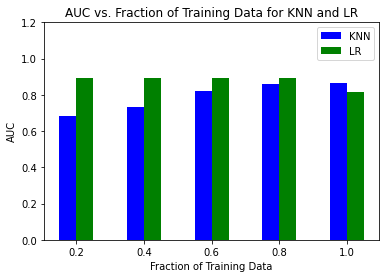

In [ ]:
# KNN and LR auc's for varying training fractions
knn_aucs, lr_aucs = aucs()

# add the aucs for the full training data
knn_aucs.append(knn_auc)
lr_aucs.append(lr_auc)

#bar plot of auc for varying training % 
fracs= np.array([0.2, 0.4, 0.6, 0.8, 1])

ax = plt.subplot()
ax.bar(fracs-0.025, knn_aucs, width=0.05, color='b', align='center', label="KNN")
ax.bar(fracs+0.025, lr_aucs, width=0.05, color='g', align='center', label="LR")
ax.set_ylim([0, 1.2])
plt.legend()
plt.title("AUC vs. Fraction of Training Data for KNN and LR")
plt.xlabel("Fraction of Training Data")
plt.ylabel("AUC")
plt.show()

#MR Experiments

In [ ]:
#COMPARE ACCURACY WITH KNN
from sklearn.metrics import accuracy_score
knn = KNeighborsClassifier(n_neighbors=1)

# need to standardize the data
x_news = (x_news - np.mean(x_news))/np.std(x_news)
x_news_test = (x_news_test - np.mean(x_news_test))/np.std(x_news_test)

knn.fit(x_news, y_news) # train knn

knn_preds = knn.predict(x_news_test)
knn_acc = accuracy_score(y_news_test, knn_preds)
print(knn_acc)

0.5410872313527181


In [ ]:
#convert training data to pandas dataframe
x_news_df = pd.DataFrame(x_news)
y_news_df = pd.DataFrame(y_news)

# randomly select several percentages for training
x_news_twenty = x_news_df.sample(frac=0.2, random_state=42).to_numpy()
y_news_twenty = y_news_df.sample(frac=0.2, random_state=42).to_numpy() #.squeeze()

#We need to check whether this sampling messes up the order of labels and x's which would explain the 0.25 % accuracy later and the sudden jump to 0.45% for the full data-set

x_news_fourty = x_news_df.sample(frac=0.4, random_state=42).to_numpy()
y_news_fourty = y_news_df.sample(frac=0.4, random_state=42).to_numpy() #.squeeze()

x_news_sixty = x_news_df.sample(frac=0.6, random_state=42).to_numpy()
y_news_sixty = y_news_df.sample(frac=0.6, random_state=42).to_numpy() #.squeeze()

x_news_eighty = x_news_df.sample(frac=0.8, random_state=42).to_numpy()
y_news_eighty = y_news_df.sample(frac=0.8, random_state=42).to_numpy() #.squeeze()

In [ ]:
# train on 20%
multi_r.fit(x_news_twenty, y_news_twenty)
news_twenty_acc = multi_r.mult_accuracy(y_news_test, multi_r.predict(x_news_test))
print("Testing multi_r.mult_accuracy using 20% training data: ", news_twenty_acc)

# train on 40%
multi_r.fit(x_news_fourty, y_news_fourty)
news_fourty_acc = multi_r.mult_accuracy(y_news_test, multi_r.predict(x_news_test))
print("Testing multi_r.mult_accuracy using 40% training data: ", news_fourty_acc)

# train on 60%
multi_r.fit(x_news_sixty, y_news_sixty)
news_sixty_acc = multi_r.mult_accuracy(y_news_test, multi_r.predict(x_news_test))
print("Testing multi_r.mult_accuracy using 60% training data: ", news_sixty_acc)

# train on 80%
multi_r.fit(x_news_eighty, y_news_eighty)
news_eighty_acc = multi_r.mult_accuracy(y_news_test, multi_r.predict(x_news_test))
print("Testing multi_r.mult_accuracy using 80% training data: ", news_eighty_acc)

100%|██████████| 1000/1000 [00:00<00:00, 1231.28it/s]


Testing multi_r.mult_accuracy using 20% training data:  0.6194690265486725


100%|██████████| 1000/1000 [00:01<00:00, 795.89it/s]


Testing multi_r.mult_accuracy using 40% training data:  0.6428571428571429


100%|██████████| 1000/1000 [00:03<00:00, 290.37it/s]


Testing multi_r.mult_accuracy using 60% training data:  0.6219974715549936


100%|██████████| 1000/1000 [00:02<00:00, 426.96it/s]

Testing multi_r.mult_accuracy using 80% training data:  0.634007585335019


<function matplotlib.pyplot.show(*args, **kw)>

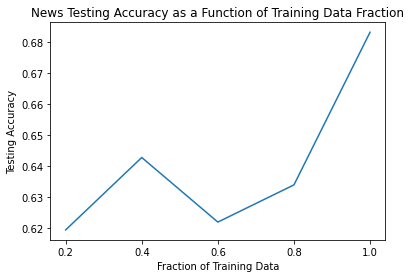

In [ ]:
# MR testing accuracy as a function of trainin data size
accuracies = [news_twenty_acc, news_fourty_acc, news_sixty_acc, news_eighty_acc, news_testing_acc]
data_fracs = ['0.2', '0.4', '0.6', '0.8', '1.0']

plt.plot(data_fracs, accuracies)
plt.title("News Testing Accuracy as a Function of Training Data Fraction")
plt.ylabel("Testing Accuracy")
plt.xlabel("Fraction of Training Data")
plt.show

In [ ]:
def accs(fracs=[0.2, 0.4, 0.6, 0.8]):

  knn_accs = []
  mr_accs = []

  #convert training data to pandas dataframe
  x_news_df = pd.DataFrame(x_news)
  y_news_df = pd.DataFrame(y_news)

  for f in fracs:
    # get random fraction of the data
    x_news_frac = x_news_df.sample(frac=f, random_state=42).to_numpy()
    y_news_frac = y_news_df.sample(frac=f, random_state=42).to_numpy().squeeze()

    # standardize the data
    #x_news_frac = (x_news_frac - np.mean(x_news_frac))/np.std(x_news_frac)
    #x_news_test = (x_news_test - np.mean(x_news_test))/np.std(x_news_test)

    # train knn on fraction of data
    knn.fit(x_news_frac, y_news_frac) 
    #predict on testing set
    preds = knn.predict(x_news_test)
    acc = accuracy_score(y_news_test, preds)
    knn_accs.append(acc)

    #fit multiple regression model
    multi_r.fit(x_news_frac, y_news_frac)
    #get test accuracy
    mr_acc = multi_r.mult_accuracy(y_news_test, multi_r.predict(x_news_test))
    mr_accs.append(mr_acc)
  
  return knn_accs, mr_accs

100%|██████████| 1000/1000 [00:04<00:00, 240.82it/s]


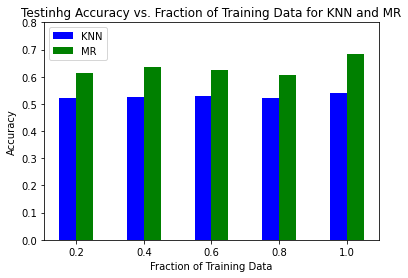

In [ ]:
knn_accs, mr_accs = accs()

#append the accuracy for training on full set
knn_accs.append(knn_acc)
mr_accs.append(news_testing_acc)

#bar plot
fracs= np.array([0.2, 0.4, 0.6, 0.8, 1])

ax = plt.subplot()
ax.bar(fracs-0.025, knn_accs, width=0.05, color='b', align='center', label="KNN")
ax.bar(fracs+0.025, mr_accs, width=0.05, color='g', align='center', label="MR")
ax.set_ylim([0, 0.8])
plt.legend()
plt.title("Testinhg Accuracy vs. Fraction of Training Data for KNN and MR")
plt.xlabel("Fraction of Training Data")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# need to standardize the data
x_news_10 = (x_news_10 - np.mean(x_news_10))/np.std(x_news_10)
x_news_test_10 = (x_news_test_10 - np.mean(x_news_test_10))/np.std(x_news_test_10)

x_news_50 = (x_news_50 - np.mean(x_news_50))/np.std(x_news_50)
x_news_test_50 = (x_news_test_50 - np.mean(x_news_test_50))/np.std(x_news_test_50)

multi10_r= MultipleLogisticRegressor(4)
multi50_r= MultipleLogisticRegressor(4)

# train on top 10 features
multi10_r.fit(x_news_twenty, y_news_twenty)
news_10_acc = multi10_r.mult_accuracy(y_news_test, multi_r.predict(x_news_test))
print("\nTesting multi_r.mult_accuracy using 10 features (per class): ", news_twenty_acc)
# train KNN to compare
knn10 = KNeighborsClassifier(n_neighbors=1)
knn10.fit(x_news_10, y_news) # train knn
knn10_preds = knn10.predict(x_news_test_10)
knn10_acc = accuracy_score(y_news_test, knn10_preds)
print(knn10_acc)

# train on top 50 features
multi50_r.fit(x_news_fourty, y_news_fourty)
news_50_acc = multi50_r.mult_accuracy(y_news_test, multi_r.predict(x_news_test))
print("\nTesting multi_r.mult_accuracy using 50 features (per class): ", news_fourty_acc)
# train KNN to compare
knn50 = KNeighborsClassifier(n_neighbors=1)
knn50.fit(x_news_50, y_news) # train knn
knn50_preds = knn50.predict(x_news_test_50)
knn50_acc = accuracy_score(y_news_test, knn50_preds)
print(knn50_acc)

100%|██████████| 1000/1000 [00:00<00:00, 1570.15it/s]



Testing multi_r.mult_accuracy using 10 features (per class):  0.6194690265486725
0.36599241466498106


100%|██████████| 1000/1000 [00:00<00:00, 1007.01it/s]



Testing multi_r.mult_accuracy using 50 features (per class):  0.6428571428571429
0.5120101137800253


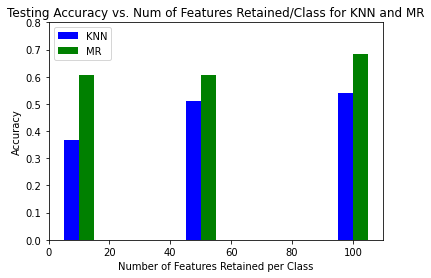

In [ ]:
#Plotting Results
knn_accs = [knn10_acc, knn50_acc, knn_acc]
mr_accs = [news_10_acc, news_50_acc, news_testing_acc]

fracs= np.array([10, 50, 100])
ax = plt.subplot()
ax.bar(fracs-2.5, knn_accs, width=5, color='b', align='center', label="KNN")
ax.bar(fracs+2.5, mr_accs, width=5, color='g', align='center', label="MR")
ax.set_ylim([0, 0.8])
plt.legend()
plt.title("Testing Accuracy vs. Num of Features Retained/Class for KNN and MR")
plt.xlabel("Number of Features Retained per Class")
plt.ylabel("Accuracy")
plt.show()